# Gans - Data Engineering: Pipelines on the Cloud

## Introduction 

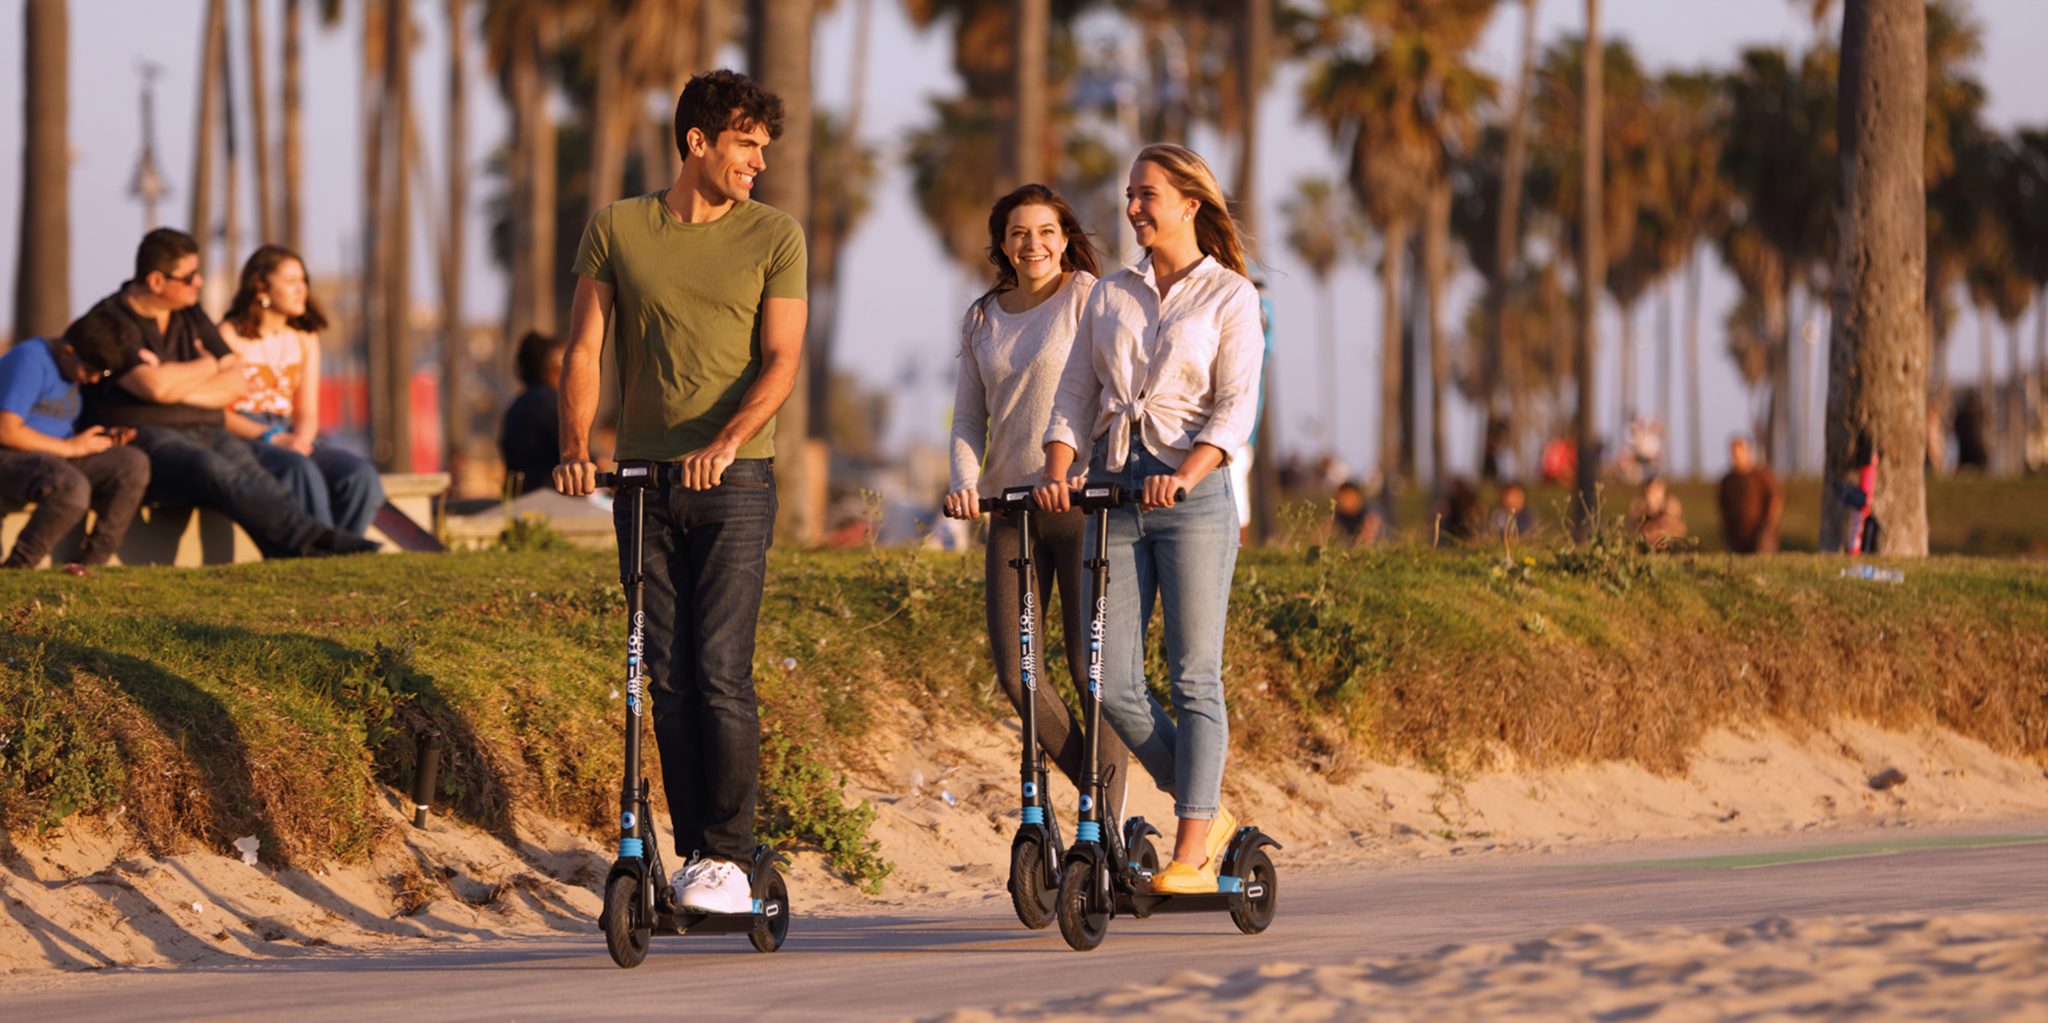

In [13]:
from IPython.display import Image
Image(filename='scoothers.png',width=800, height=400)

Gans has seen that its operational success depends on having a good prediction of their e-scooters parked where users need them.

Predictive modelling is certainly in the roadmap, but the first step is to collect more data. This is where you come in: your task will be to collect data from external sources that can potentially help Gans predict e-scooter movement. 


Ideally, scooters get rearranged organically by having certain users moving from point A to point B, and then an even number of users moving from point B to point A. There are some elements that create asymmetries. Here are some of them:

- Weather conditions, for example: Whenever it starts raining, e-scooter usage decreases drastically.
- Increment of people's trafic in specific area and hours of the city, for example: airplanes with back-pack young tourists lands, a lot of scooters are needed close to the airport.

There are some actions that the company can perform to solve these asymmetries, namely:

- Use a truck to move scooters around.
- Create economic incentives for users to pick or leave scooters in certain areas, like the images below shows.

## Objective

Since data is needed every day, in real time and accessible by everyone in the company, the challenge is going to be to assemble and automate a data pipeline in the cloud.

To execute the cloud automated data collection pipeline, was used:

1) Data collection from diferent APIs sources
2) Python language
3) AWS Cloud Compute Service (RDS, Lambda)
4) Create a Github public repository (https://github.com/JLMA-Pro-Trading/Data-Engineering-Pipelines-on-the-Cloud)

## Initial Data Collection

### Pre-requirements

1) for this project was selected as sample, 15 of the most populated cities from Europe and saved in a CSV file (city,country).
2) GeoNames geographical database API service (For more details, please visit their webpage: https://www.geonames.org/)
3) Downloand from GeoNames the world cities CSV, where you can find the unique geo_nameid numbers for each country-city
4) OpenWeather Weather database API service (For more details, please visit their webpage: https://home.openweathermap.org/)
5) RapidAPI Airports and Flights database API service (For more details, please visit their webpage: https://rapidapi.com/)

In the following, you can see what was the structure of the Pipeline:

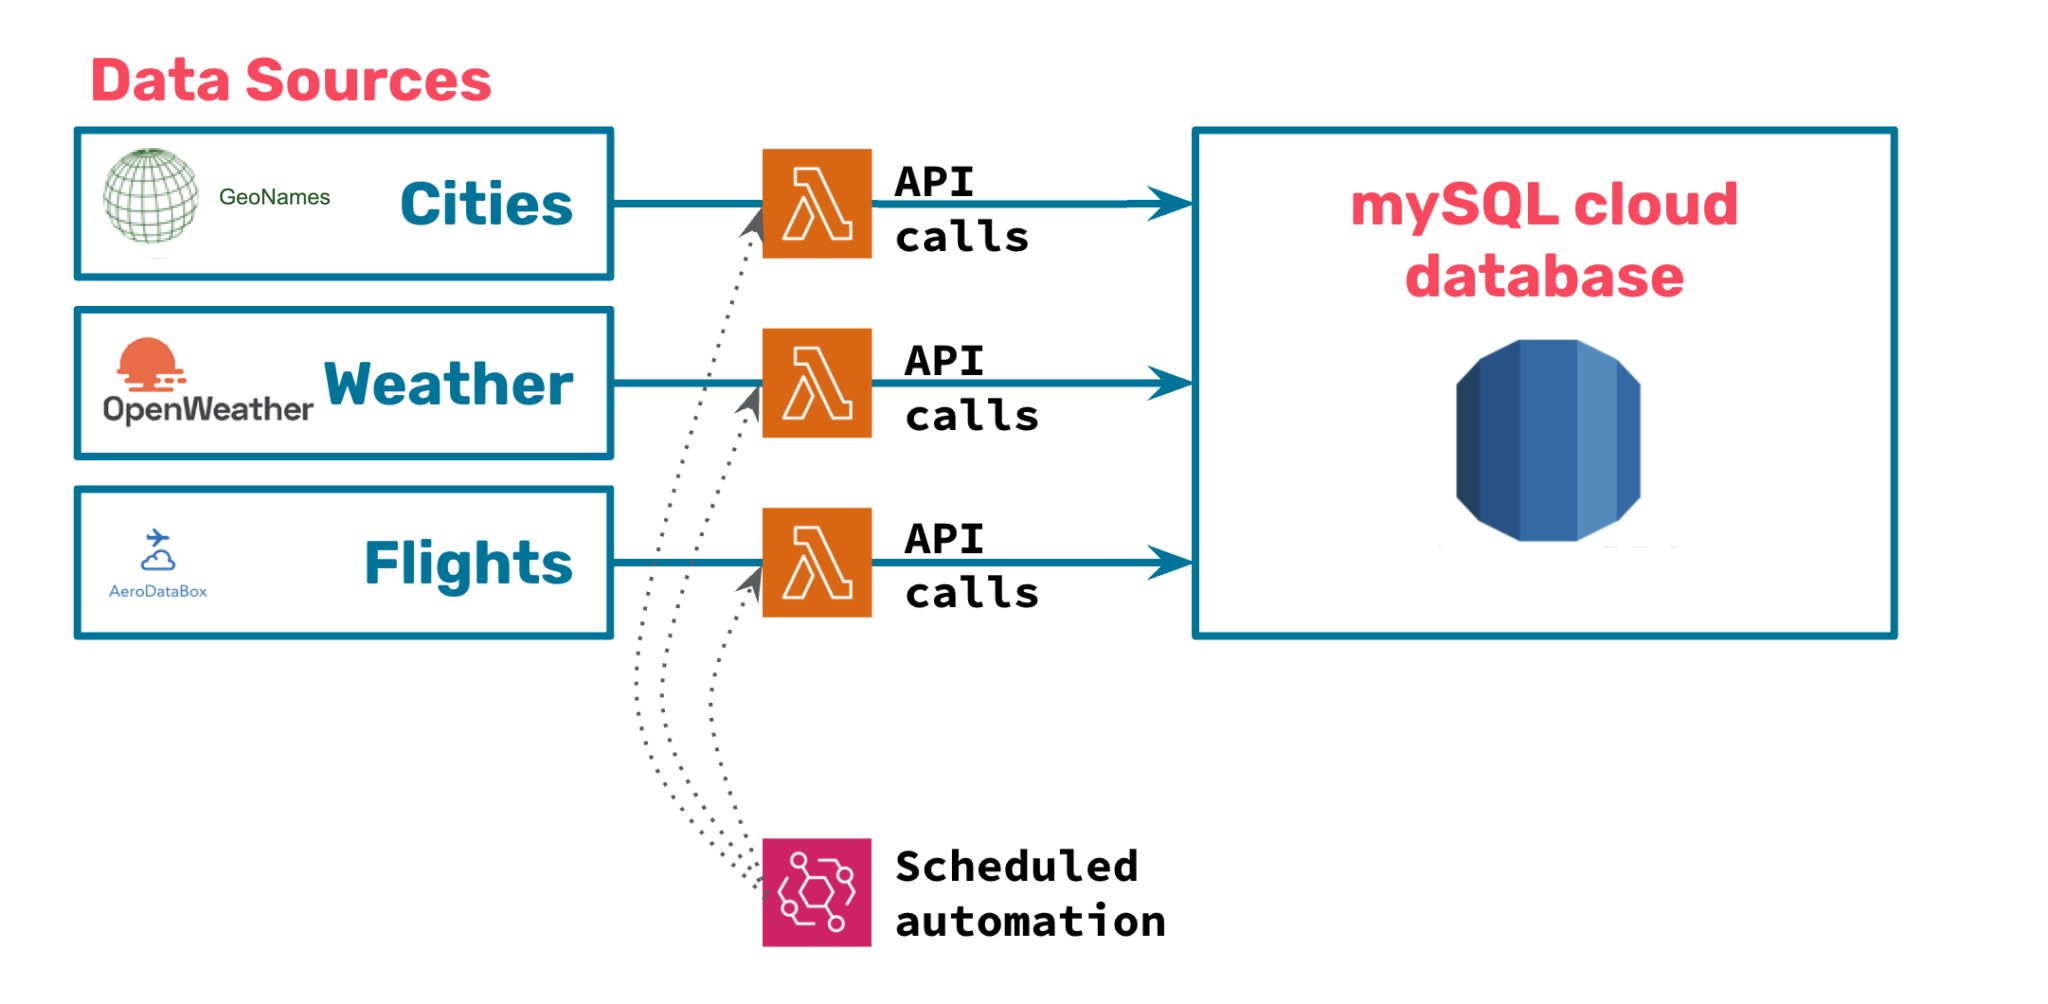

In [3]:
from IPython.display import Image
Image(filename='data_pipeline.png',width=800, height=400)

### Cities

The following code was used to collect the Geographical data and generate the csv file that will be use for filling the airports table in the Data Base

#### Code to collect the geographical data:

```python

import geocoder
import pandas as pd

wc = pd.read_csv('world_cities.csv')
countries= pd.read_csv('EuroCitiesPopulation15_.csv').country
cities = pd.read_csv('EuroCitiesPopulation15_.csv').name

city_id=[]
for co,ci in zip(countries,cities):
    city_id=city_id+[(wc.set_index('country').loc[co].set_index('name').loc[ci].geonameid)]
    
    
lat=[]
lng=[]
population=[]
country_code=[]
time_zone=[]
east=[]
south=[]
north=[]
west=[]

for c in city_id:

    # DATA COLLECTION:

    g = geocoder.geonames(c, method='details', key='jlma_ve84')
    lat             = lat+[(g.geojson['features'][0]['properties']['lat'])]
    lng             = lng+[(g.geojson['features'][0]['properties']['lng'])]
    population      = population+[(g.geojson['features'][0]['properties']['population'])]
    country_code    = country_code+[(g.geojson['features'][0]['properties']['country_code'])]
    time_zone       = time_zone+[3600*(g.geojson['features'][0]['properties']['raw']['timezone']['gmtOffset'])]
    east            = east+[(g.geojson['features'][0]['properties']['raw']['bbox']['east'])]
    south           = south+[(g.geojson['features'][0]['properties']['raw']['bbox']['south'])]
    north           = north+[(g.geojson['features'][0]['properties']['raw']['bbox']['north'])]
    west            = west+[(g.geojson['features'][0]['properties']['raw']['bbox']['west'])]  
    
cities_dic = {'city_id': city_id,
              'city': cities, 
              'country':countries, 
              'Code': country_code, 
              'Population': population, 
              'Time_Zone': time_zone, 
              'Latitud': lat, 
              'Logitud': lng, 
              'East': east, 
              'South': south, 
              'North': north, 
              'West': west}
cities_df  = pd.DataFrame.from_dict(cities_dic)
cities_df.to_csv('cities.csv', index=False) 


```

### Airports

The following code was used to collect the Airports data and generate the csv file that will be use for filling the airports table in the Data Base

#### Code to collect the Airports data:

```python

import requests
import datetime
import pandas as pd
import numpy as np

cities_df = pd.read_csv('cities.csv')
cities = cities_df['city']

airports = pd.DataFrame(columns=['city','city_id','lat','lon','icao','iata','name'])


for city in cities:
    lat = float(cities_df.loc[cities_df['city']==city]['Latitud'])
    lon = float(cities_df.loc[cities_df['city']==city]['Logitud'])

    url = f"https://aerodatabox.p.rapidapi.com/airports/search/location/{lat}/{lon}/km/50/16"
    
    querystring = {"withFlightInfoOnly":"0"}
    
    headers = {
            	"X-RapidAPI-Key": "2ef471dfcbmshec01fd033aae0e3p10a740jsn9a6d81f2bead",
            	"X-RapidAPI-Host": "aerodatabox.p.rapidapi.com"
            }
    
    response = requests.request("GET", url, headers=headers)#, params=querystring)
    print('Status code',response.status_code)
    airp_js = response.json()
    
    for a in airp_js["items"]:
        airports = airports.append({'city':city,
                      'city_id': cities_df[cities_df['city']==city].city_id.iloc[0],
                      'lat':a["location"]["lat"],
                      'lon':a["location"]["lon"],
                      'icao':a["icao"],
                      'iata':a["iata"],
                      'name':a["name"]
                      }
                      ,ignore_index=True)

        
airports.to_csv('airports_new.csv', index=False)

```

### Flights ans Weather

Collecting Flights ans Weather data was located at the end the pipeline at the AWS Lambda automation data collection

## Create a database model on the AWS cloud for MySQL instance

### Pre-requirements:

1.   Create AWS cloud account
2.   Create a Amazon Relational Database Service (AWS RDS) MySQL instance.
3.   Install MySQL Workbench



### Create the database structure

The next step is to create the database-schema. It represents the structure of the data you want to store. The picture below shows the SQL-code that was used to create Gans' database.

``` mysql

CREATE DATABASE gans;
USE gans;


CREATE TABLE IF NOT EXISTS cities (
	city_id INT,
    city VARCHAR(200),
    country VARCHAR(200),
    country_code CHAR(2),
    population INT,
    time_zone INT,
    latitude FLOAT,
    longitude FLOAT,
   	PRIMARY KEY(city_id)
);

SELECT * FROM cities;


CREATE TABLE IF NOT EXISTS weathers (
	weather_id INT auto_increment,
    city_id INT,
    time_utc INT,
    local_time CHAR(20),
    temperature FLOAT,
    humidity FLOAT,
    cloudiness_pc INT,
    wind_speed FLOAT,
    precipitation_prob FLOAT,
    rain_volume FLOAT,
    snow_volume FLOAT,
    PRIMARY KEY(weather_id),
    FOREIGN KEY(city_id) REFERENCES cities(city_id)
);

SELECT * FROM weathers;



CREATE TABLE IF NOT EXISTS airports (
	city_id INT,
    lat FLOAT,
    lon FLOAT,
    icao CHAR(4),
    iata CHAR(3),
    name VARCHAR(200),
    PRIMARY KEY(icao),
    FOREIGN KEY(city_id) REFERENCES cities(city_id)
);

SELECT * FROM airports;




CREATE TABLE IF NOT EXISTS flights (
	flights_id INT auto_increment,
    icao CHAR(4),
    date CHAR(10),
    hour_day CHAR(5),
    num_of_arriv INT,
    num_of_depart INT,
    PRIMARY KEY(flights_id),
    FOREIGN KEY(icao) REFERENCES airports(icao)
);

SELECT * FROM flights;
```

This code will create four tables and their respective keys.

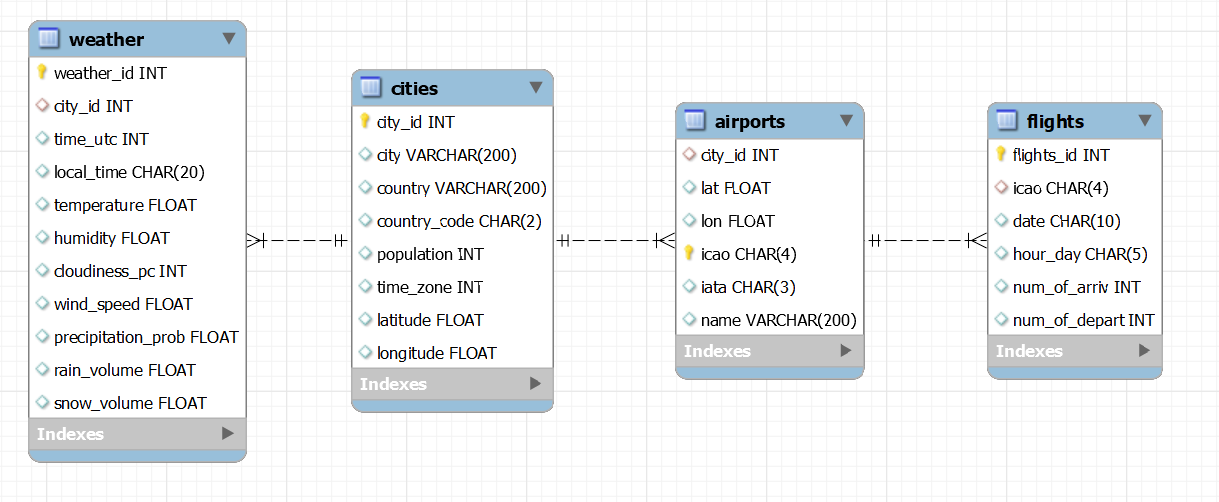

The picture shown above graphically represents these four tables and their relations. The primary keys are indicated by the yellow symbols. Foreign keys are indicated by the pink diamonds. Every foreign key is a primary key of another table.

In the next step we filled in the data for ```cities``` and ```airports```.

In [ ]:
import pandas as pd
import requests
import sqlalchemy
import config as cfg
import pymysql



schema="gans"
host=cfg.DATABASE_HOST
user=cfg.DATABASE_USER
password=cfg.DATABASE_PASSWORD
port=cfg.DATABASE_PORT
con = f'mysql+pymysql://{user}:{password}@{host}:{port}/{schema}'

path='PATH'

cities_df = pd.read_csv(path+'cities.csv')
cities_df.to_sql('cities', 
              if_exists='append', 
              con=con, 
              index=False)

airports = pd.read_csv(path+'airports.csv')
airports.to_sql('airports', 
              if_exists='append', 
              con=con, 
              index=False)

The code above establishes a connection between the RDS-instance and your local code in line 9 to 15. The code in line 18 to 23 inserts the ```cities.csv``` into the ```cities```-table inside the database. The code in line 24 to 29 inserts the ```airports.csv``` into the ```airports```-table.

### Create the RDS instance

Amazon Relational Database Service (Amazon RDS) is a service that simpliflies the setup of a relational database. In this case we were able to use the **Free tier** template which does not create any costs.

As soon as the instance is running, it will be ready for beeing connected to the database-template that has been created locally using MySQL Workbench.

### Connect the template to the RDS instance

The next step is to establish a connection that links the local database template to the RDS instance, that has been created using the AWS.

NOTE: In order to work correctly it is required to explecitly allow traffic that will be created by any connection source which is trying to interact with the databse.

## AWS Lambda automation data collection

In [ ]:
from IPython.display import Image

In [ ]:
**Pipeline Automation:** automate the whole data collection and storage process

In this project I use Amazon Web Services (AWS) as service provider for cloud computing. Starting my adventure
in the cloud is straigthforward with creating an account that comes with some free services for the first
12 months.Using the documentation helps to easily create the database instance.Write down your
password and copy the database endpoint as you will need this to connect to your database from your scripts.
    
After that next step we used MYSQL Workbench to create a new database in my cloud RDS instance with the
same script we used for my local database.To fill my cloud database with my gathered data I will use 
another AWS service — Lambda functions. To give the lambda functions access to the RDS service 
I first need to create a new Role in the AWS Identity and Access Management (IAM).

Now, I just need to transfer my data collection scripts from my jupyter notebook to one or more
lambda functions.Having one lambda function for weather data and flights data will make it easier to
automate the data collection process at the end. Within the lambda function you need to make sure that your main code is in the provided lamdba handler function `def lamdbda_handler(event, context):`

Then create a test event to test your function. When requesting data from an API sometimes a timeout error occurs and you should configure the timeout settings for the function to something bigger than 3 seconds (the default value). When everything runs fine you will see something like this as response.

<img src="Lambda_function_excution.png" width="1794" height="879"

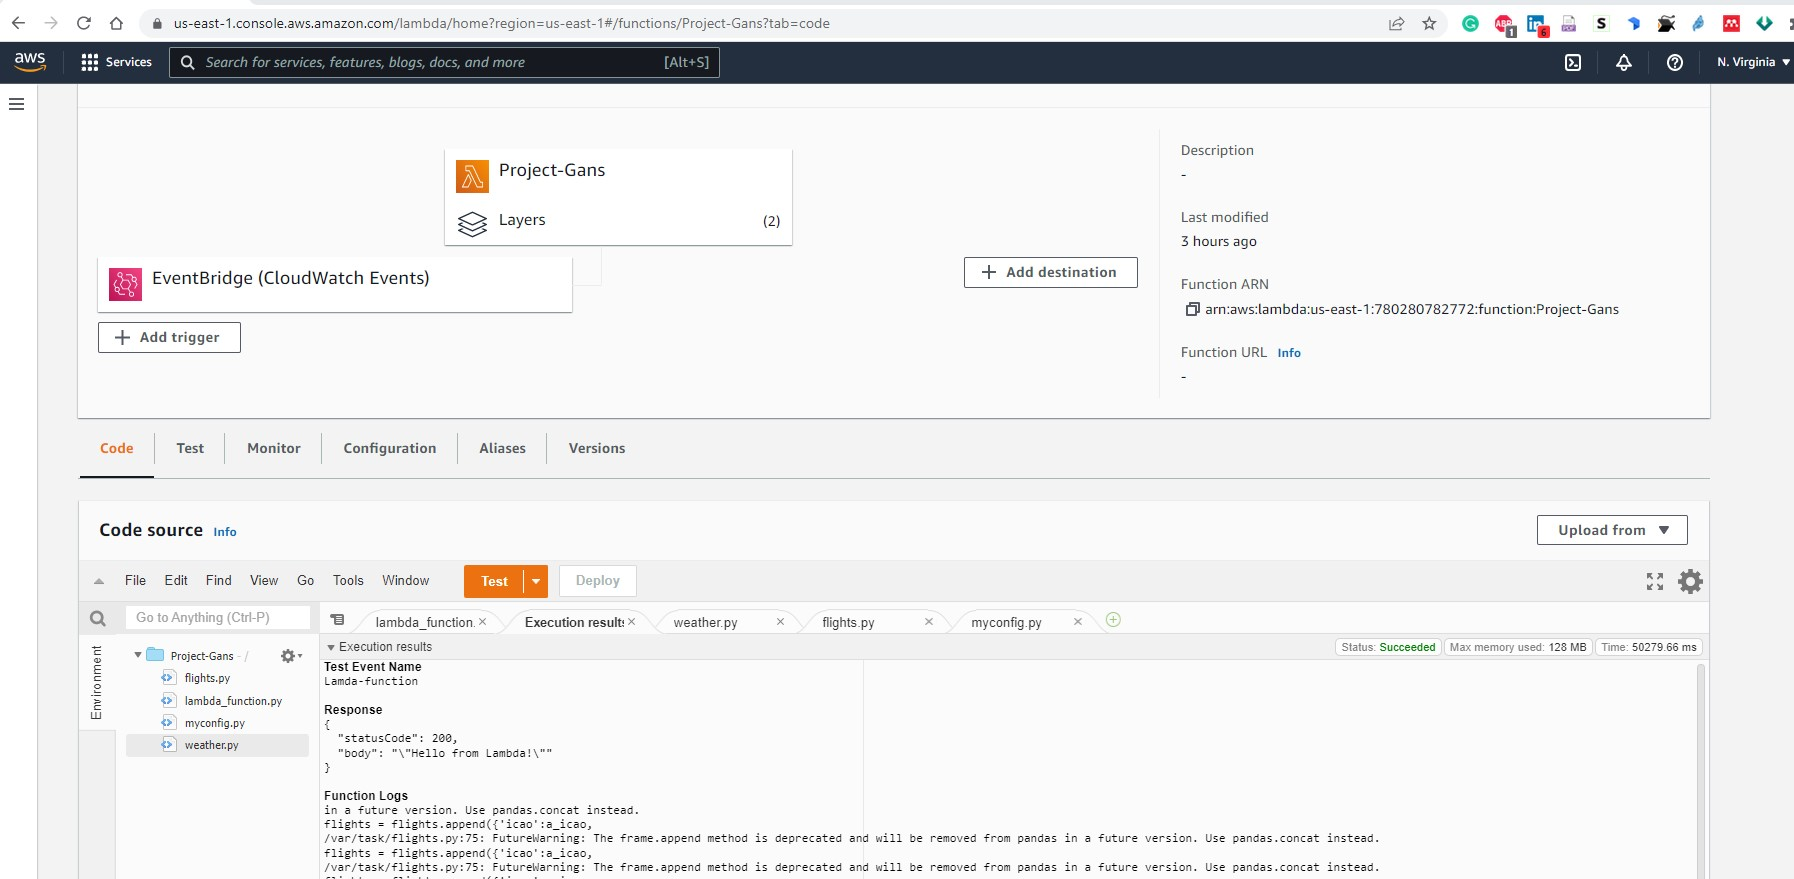

In [8]:
Image(filename='Lambda_function_excution.jpg',width=800, height=400)
#fig.caption: Response “null”, no error, lamdba function run as expected

As we did not specify any output for my lamdba function — it just send the data to the database — we get “null” as response and we know that everything is fine. In MySQL workbench we can query the database, get the results and also see that my data is there.

In [10]:
Image(url="MYSQL_weather-1.jpg", width=800, height=400)
#Figure_caption:The data can be queried from the rds cloud database through MySQL workbench.

### **Automate the Data Engineering Pipeline** ###

So far we did the same locally and in the cloud — creating a database, collecting some data and saving it
in the database. Some added value now comes from the possibility to easily create event triggers that
automate the lamdba functions. This can be done in AWS Cloud/AWS EventBridge. Using Cron expressions
it is quite easy to create rules when your lamdba function should be executed.

In [11]:
Image(url="Timetrigger.jpg", width=800, height=400)

figure caption: The cron expression to run the lambda function every day at 24 o’clock GMT.

Because we run the weather and flight lambda function, that collects the 3h forecast for 5 days, every day we will get lotb of duplicated data entries in my database. But I always want to have the latest weather data for a specific date and thus I will need to remove the duplicated items afterwards when analysing the data.

## Project Summary

Now that we have an automated Data Engineering Pipeline running in the Cloud we will have a 
look at the flaws of this project and some future tasks.

**Data collection through web scraping.**
**Go for an API, that offers the data that you need, whenever you find one. In a real company there might even be some budget for the ones that are not free to use or only allow limited requests.**

**The AWS universe offers such a huge amount of services and we only touched a very small fraction. However the tools we used served very well for the purpose of implementing an automated data engineering pipeline in the cloud.**

**As my lamdba functions run automatically now I just need to check from time to time whether errors occur or maybe implement an email for this task.**

Now that the weather prediction for the following 5 days, plus the flights arrival and departures **detailed data per hour** is available in the database and updating in day base, real time and accessible by everyone in the company, it will be easy for you Data Scientist to make a good prediction of their e-scooters parked where users need them and provide some valueable insights for Gans company.